In [163]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import davies_bouldin_score


In [164]:
final_movie_data = pd.read_csv('data/movies_with_tmdb_features_and_tags.csv')

In [165]:
# drop the title column and the movieId column
final_movie_data = final_movie_data.drop(['title'], axis=1)
final_movie_data = final_movie_data.drop(['spoken_languages'], axis=1)

In [166]:
print(final_movie_data.head())

   movieId  popularity  vote_average  vote_count  runtime release_date  \
0        1     134.972          8.00       18317       81   1995-10-30   
1        2      15.958          7.24       10465      104   1995-12-15   
2        3      21.540          6.50         375      101   1995-12-22   
3        4      15.297          6.30         162      127   1995-12-22   
4        5      35.745          6.20         725      106   1995-12-08   

           production_countries    revenue    budget  adult  \
0  ['United States of America']  394436586  30000000  False   
1  ['United States of America']  262821940  65000000  False   
2  ['United States of America']   71500000  25000000  False   
3  ['United States of America']   81452156  16000000  False   
4  ['United States of America']   76594107         0  False   

                                        genres          tag  
0  Adventure|Animation|Children|Comedy|Fantasy         toys  
1                   Adventure|Children|Fantasy    ad

# Performing the clustering on the dataset

In [167]:
unique_genres = final_movie_data['genres'].str.split('|').explode().unique()
print(unique_genres)

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


In [168]:
empty_rows_count = final_movie_data[final_movie_data['production_countries'] == '[]'].shape[0]
print(f"Number of rows where countries is an empty list: {empty_rows_count}")


final_movie_data = final_movie_data[final_movie_data['production_countries'].apply(lambda x: x != '[]')]

# Reset index if needed
final_movie_data.reset_index(drop=True, inplace=True)

empty_rows_count = final_movie_data[final_movie_data['production_countries'] == '[]'].shape[0]
print(f"Number of rows where countries is an empty list: {empty_rows_count}")


Number of rows where countries is an empty list: 834
Number of rows where countries is an empty list: 0


In [169]:

country_to_continent = {
    # North America
    'United States of America': 'North America', 'Canada': 'North America', 'Mexico': 'North America', 'Bahamas': 'North America',
    'Dominican Republic': 'North America', 'Cuba': 'North America', 'Puerto Rico': 'North America', 
    # South America
    'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America', 'Peru': 'South America', 
    'Colombia': 'South America', 'Uruguay': 'South America', 'Venezuela': 'South America', 'Paraguay': 'South America', 
    # Europe
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe', 
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Switzerland': 'Europe', 'Sweden': 'Europe', 'Portugal': 'Europe',
    'Austria': 'Europe', 'Denmark': 'Europe', 'Ireland': 'Europe', 'Norway': 'Europe', 'Poland': 'Europe', 
    'Finland': 'Europe', 'Greece': 'Europe', 'Hungary': 'Europe', 'Czech Republic': 'Europe', 'Slovakia': 'Europe', 
    'Iceland': 'Europe', 'Russia': 'Europe', 'Serbia and Montenegro': 'Europe', 'Macedonia': 'Europe',
    'Bulgaria': 'Europe', 'Yugoslavia': 'Europe', 'Luxembourg': 'Europe', 'Ukraine': 'Europe', 'Romania': 'Europe', 
    'Estonia': 'Europe', 'Lithuania': 'Europe', 'Albania': 'Europe', 'Latvia': 'Europe', 'Slovenia': 'Europe', 
    # Asia
    'China': 'Asia', 'Japan': 'Asia', 'India': 'Asia', 'South Korea': 'Asia', 'Iran': 'Asia', 'Thailand': 'Asia', 
    'Hong Kong': 'Asia', 'Malaysia': 'Asia', 'Taiwan': 'Asia', 'Philippines': 'Asia', 'Turkey': 'Asia', 'Israel': 'Asia',
    'Vietnam': 'Asia', 'Indonesia': 'Asia', 'Singapore': 'Asia', 'Jordan': 'Asia', 'Lebanon': 'Asia', 
    'Bangladesh': 'Asia', 'Pakistan': 'Asia', 'Sri Lanka': 'Asia', 'Saudi Arabia': 'Asia', 'Afghanistan': 'Asia', 
    'Kuwait': 'Asia', 'United Arab Emirates': 'Asia', 'Qatar': 'Asia', 'Myanmar': 'Asia', 'Kazakhstan': 'Asia', 
    # Africa
    'South Africa': 'Africa', 'Egypt': 'Africa', 'Morocco': 'Africa', 'Tunisia': 'Africa', 'Algeria': 'Africa', 
    'Cameroon': 'Africa', 'Senegal': 'Africa', 'Burkina Faso': 'Africa', 'Zimbabwe': 'Africa', 'Ivory Coast': 'Africa', 
    'Libya': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa', 'Uganda': 'Africa', 'Angola': 'Africa', 
    'Mali': 'Africa', 'Niger': 'Africa', 'Ghana': 'Africa', 'Rwanda': 'Africa', 'Ethiopia': 'Africa', 
    # Oceania
    'Australia': 'Oceania', 'New Zealand': 'Oceania', 'Papua New Guinea': 'Oceania', 'Solomon Islands': 'Oceania', 
    # For other countries not listed, include as needed
}




In [170]:
import ast


continents = ['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']
for continets in continents:
    final_movie_data[continets] = 0

for i, row in final_movie_data.iterrows():
    countries = row['production_countries']
    if isinstance(countries, str):
        countries = ast.literal_eval(countries)
    for country in countries:
        continent = country_to_continent.get(country, None)

        if continent: 
            final_movie_data.at[i, continent] = 1

In [171]:
final_movie_data = final_movie_data.drop(['production_countries'], axis=1)

In [172]:
# converting the release_date to a numerical feature
# We choose to convert the release date to a numerical feature represented by the hours from the first movie's release date.
# We made this decision instead of saving the dates as year and month column. 
# The reason is that we would like to capture the time difference between the movies rather than seasonal or yearly patterns.
final_movie_data['release_date'] = pd.to_datetime(final_movie_data['release_date'])
first_release_date = final_movie_data['release_date'].min()
final_movie_data['release_date'] = (final_movie_data['release_date'] - first_release_date).dt.total_seconds() / (60 * 60 * 24)


# hot-k encoding for 'genres' column
# We felt that the genre feature was so important that we transformed it into a one-hot encoding format.
# This way, we can use the genre information in the clustering process.
# Step 1: Create a separate column for each genre
for genre in unique_genres:
    # Check if each genre is in the 'genre' column and create a binary column
    final_movie_data[genre] = final_movie_data['genres'].apply(lambda x: 1 if genre in x.split('|') else 0)

# Drop the original 'genre' column if needed
final_movie_data = final_movie_data.drop(columns=['genres'])


# We transformed the 'adult' column into a binary column.

final_movie_data['adult'] = final_movie_data['adult'].apply(lambda x: 1 if x == 'True' else 0)



In [173]:
print(final_movie_data.columns)

Index(['movieId', 'popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'revenue', 'budget', 'adult', 'tag', 'North America',
       'South America', 'Europe', 'Asia', 'Africa', 'Oceania', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX',
       'Documentary', 'War', 'Musical', 'Western', 'Film-Noir',
       '(no genres listed)'],
      dtype='object')


In [174]:
# We will use the following features for clustering

features = ['popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'revenue', 'budget', 'adult', 'North America', 'South America', 'Europe', 'Asia', 'Africa',
       'Oceania', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery',
       'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western',
       'Film-Noir', '(no genres listed)']

In [175]:
# We will apply scaling to the features
scaler = StandardScaler()
final_movie_data_scaled = final_movie_data.copy()
final_movie_data_scaled[features] = scaler.fit_transform(final_movie_data[features])

In [176]:
# Using KMeans clustering
# Define the model
kmeans = KMeans(n_clusters=28, random_state=0)

# Fit the model
kmeans.fit(final_movie_data_scaled[features])


KMeans(n_clusters=28, random_state=0)

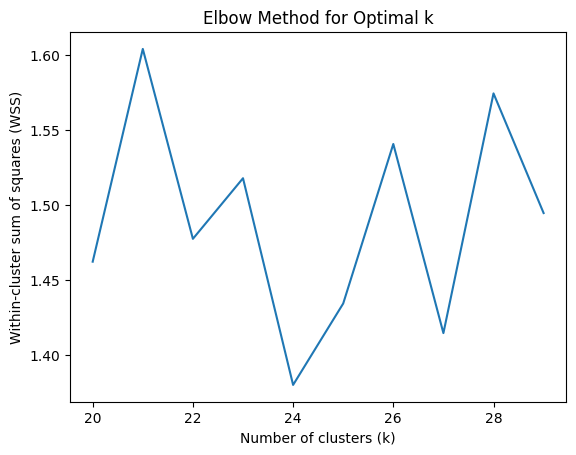

In [177]:
import matplotlib.pyplot as plt

wss = []
k_range = range(20, 30)  # Test for k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_movie_data_scaled[features])
    score = davies_bouldin_score(final_movie_data_scaled[features], kmeans.labels_)
    wss.append(score)

plt.plot(k_range, wss)
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster sum of squares (WSS)")
plt.show()

In [178]:
#hierarchical = AgglomerativeClustering(n_clusters=28)
#hierarchical.fit(final_movie_data_scaled[features])

In [179]:
# Using DBSCAN clustering
# Define the model
dbscan = DBSCAN(eps=0.8, min_samples=10)
dbscan.fit(final_movie_data_scaled[features])

DBSCAN(eps=0.8, min_samples=10)

In [180]:


# Evaluate the clustering results
db_kmeans = davies_bouldin_score(final_movie_data_scaled[features], kmeans.labels_)
db_hierarchical = davies_bouldin_score(final_movie_data_scaled[features], hierarchical.labels_)
db_dbscan = davies_bouldin_score(final_movie_data_scaled[features], dbscan.labels_)

print(f"Davies-Bouldin Index for KMeans: {db_kmeans}")
print(f"Davies-Bouldin Index for Hierarchical Clustering: {db_hierarchical}")
print(f"Davies-Bouldin Index for DBSCAN: {db_dbscan}")

Davies-Bouldin Index for KMeans: 1.4948627385728588
Davies-Bouldin Index for Hierarchical Clustering: 1.501370007409164
Davies-Bouldin Index for DBSCAN: 1.578992595302747


In [181]:
# Getting the number of elements in each cluster
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)
print(len(cluster_counts))

9     2233
21    1937
12    1709
20    1610
19    1589
22    1567
0     1444
27    1406
4     1371
16    1145
3     1012
1      871
8      831
23     812
10     792
18     761
17     757
24     737
5      635
2      446
13     443
25     412
7      339
15     326
11     209
26     191
14     134
28     108
6       74
Name: count, dtype: int64
29


In [182]:
cluster_counts = pd.Series(dbscan.labels_).value_counts()
print(cluster_counts)
print(len(cluster_counts))

-1      13963
 4       1573
 16      1306
 9       1130
 17       817
        ...  
 99        10
 101       10
 82        10
 96        10
 84        10
Name: count, Length: 110, dtype: int64
110


In [183]:
# Add the preferred cluster labels to the final_movie_data dataframe
final_movie_data['cluster'] = kmeans.labels_

# Minhashing and jaccard similarity 

- Take a users best rated movie. (Since it is most likely that the user wants to watch a movie similar)
- Find the movie's corresponding cluster
- Use min-hashing and jaccard-similarity to find the closest 10 movies

In [199]:
# Choosen movie used as reference for the recommendation

movie_id = 2
cluster_recommendation = (final_movie_data.loc[final_movie_data['movieId'] == movie_id, 'cluster'].values)[0]
print(cluster_recommendation)

28


In [185]:
print(final_movie_data.columns)

Index(['movieId', 'popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'revenue', 'budget', 'adult', 'tag', 'North America',
       'South America', 'Europe', 'Asia', 'Africa', 'Oceania', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX',
       'Documentary', 'War', 'Musical', 'Western', 'Film-Noir',
       '(no genres listed)', 'cluster'],
      dtype='object')


In [187]:
non_binary_features = ['popularity', 'vote_average', 'vote_count', 'runtime', 'revenue', 'budget', 'release_date']
binary_features = ['adult', 'North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']


feature_means = final_movie_data[non_binary_features].median()

# Step 2: Convert the features into binary values (1 if above median, 0 if below median)
# Align feature_means to the columns of final_movie_data[features] and apply the transformation
final_movie_data_binary = final_movie_data[non_binary_features].apply(lambda x: (x >= feature_means).astype(int), axis=1)

# Optional: Concatenate the binary features with the original DataFrame (if needed)
final_movie_data_binary = pd.concat([final_movie_data[['movieId', 'cluster']], final_movie_data[binary_features], final_movie_data_binary], axis=1)

# Result
print(final_movie_data_binary.head())

   movieId  cluster  adult  North America  South America  Europe  Asia  \
0        1       28      0              1              0       0     0   
1        2       28      0              1              0       0     0   
2        3       20      0              1              0       0     0   
3        4       20      0              1              0       0     0   
4        5        9      0              1              0       0     0   

   Africa  Oceania  Adventure  ...  Western  Film-Noir  (no genres listed)  \
0       0        0          1  ...        0          0                   0   
1       0        0          1  ...        0          0                   0   
2       0        0          0  ...        0          0                   0   
3       0        0          0  ...        0          0                   0   
4       0        0          0  ...        0          0                   0   

   popularity  vote_average  vote_count  runtime  revenue  budget  \
0           1    

In [202]:
# Use Minhashing and jaccard similarity to find similar movies

rec_movie_data_binary = final_movie_data_binary.loc[final_movie_data_binary['movieId'] == movie_id]
rec_movie_data_binary = rec_movie_data_binary.drop(columns=['movieId', 'cluster'])

# go thorugh every movie with the same cluster and compute the Jaccard similarity
# between the movie and the chosen movie
similar_movies = final_movie_data_binary.loc[final_movie_data_binary['cluster'] == cluster_recommendation]
similar_movies = similar_movies.drop(columns=['cluster'])

print(similar_movies.loc[similar_movies['movieId'] == movie_id])

# Compute the Jaccard similarity
jaccard_similarity = []
for i, row in similar_movies.iterrows():
    id = int(row['movieId'])
    row.drop(['movieId'], inplace=True)
    jaccard_score = sum(row == rec_movie_data_binary.iloc[0]) / len(row)
    jaccard_similarity.append((id, jaccard_score))

# Sort the dictionary by the Jaccard similarity and keep the top 10
sorted_jaccard_similarity = sorted(jaccard_similarity, key=lambda x: x[1], reverse=True)

print(sorted_jaccard_similarity[:50])


   movieId  adult  North America  South America  Europe  Asia  Africa  \
1        2      0              1              0       0     0       0   

   Oceania  Adventure  Animation  ...  Western  Film-Noir  (no genres listed)  \
1        0          1          0  ...        0          0                   0   

   popularity  vote_average  vote_count  runtime  revenue  budget  \
1           1             1           1        1        1       1   

   release_date  
1             0  

[1 rows x 35 columns]
[(2, 1.0), (158, 0.9705882352941176), (59501, 0.9705882352941176), (2124, 0.9411764705882353), (41566, 0.9411764705882353), (50601, 0.9411764705882353), (82169, 0.9411764705882353), (104074, 0.9411764705882353), (1, 0.9117647058823529), (2085, 0.9117647058823529), (2953, 0.9117647058823529), (4366, 0.9117647058823529), (6536, 0.9117647058823529), (27706, 0.9117647058823529), (56171, 0.9117647058823529), (102720, 0.9117647058823529), (551, 0.8823529411764706), (596, 0.8823529411764706), (